# Mammograms Classification with YOLO

In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import utils
from loss import yolo_loss
from model import yolov1, tiny_yolov1
from training import create_yolo_dataset


2025-06-16 19:50:13.058655: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Example Images

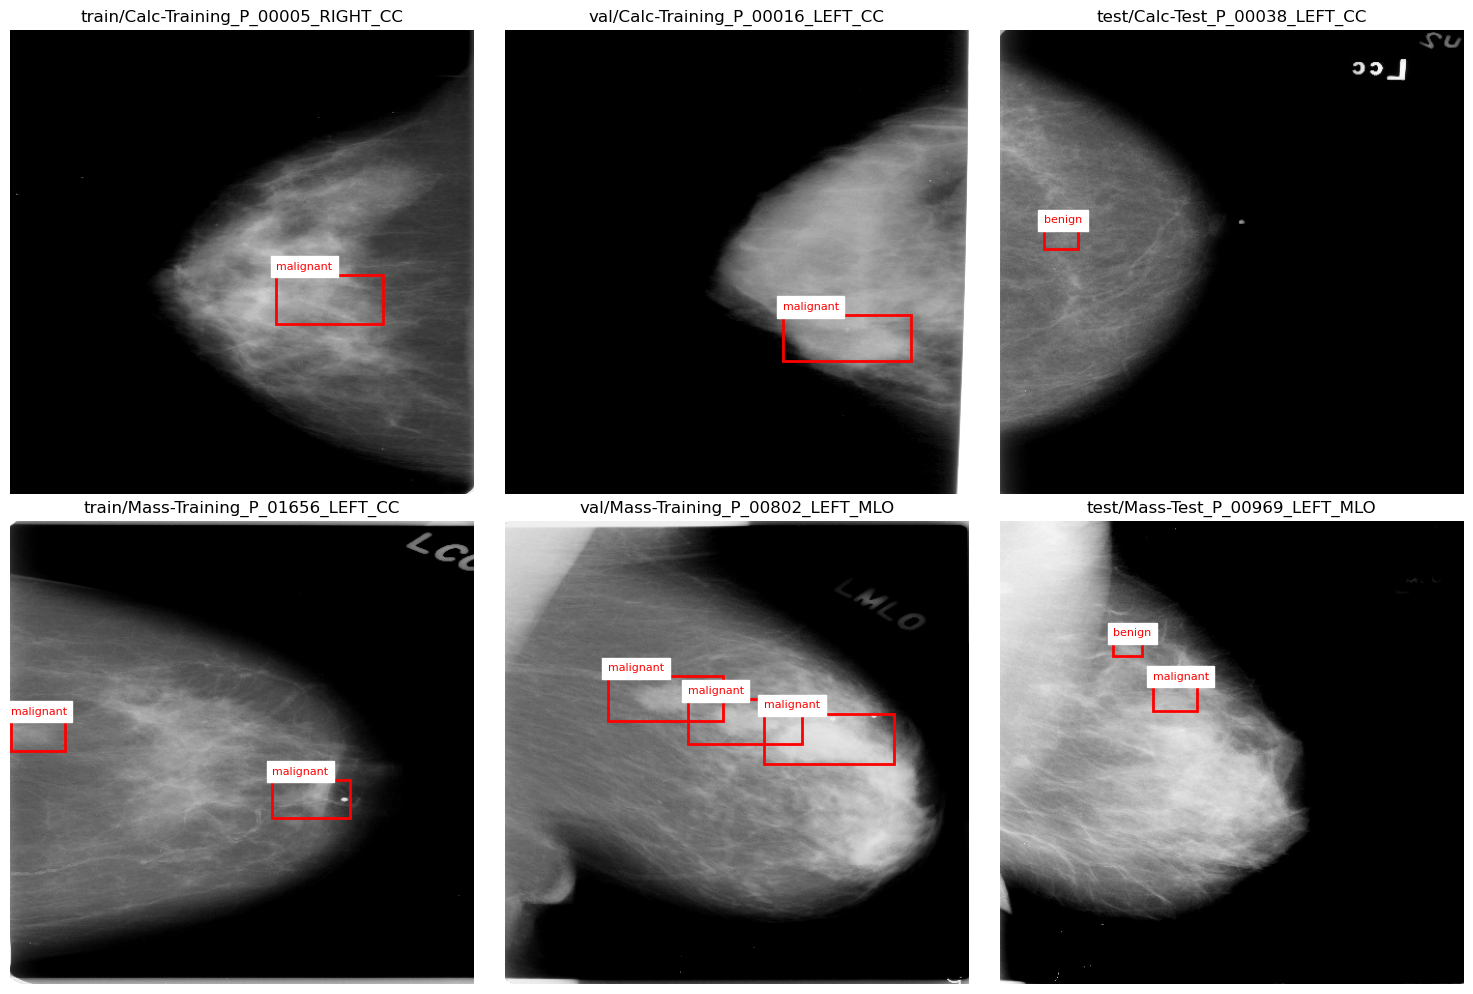

In [67]:
img_dir="data/images"
label_dir="data/labels"
img_id = ["train/Calc-Training_P_00005_RIGHT_CC", "val/Calc-Training_P_00016_LEFT_CC", "test/Calc-Test_P_00038_LEFT_CC",
          "train/Mass-Training_P_01656_LEFT_CC", "val/Mass-Training_P_00802_LEFT_MLO", "test/Mass-Test_P_00969_LEFT_MLO" ]
utils.show_batch(img_id, img_dir, label_dir)

## Load Model


In [8]:
model_tiny = tiny_yolov1()
model = yolov1()

In [9]:
model_tiny.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 448, 448, 1)]     0         
                                                                 
 convolutional_0 (Conv2D)    (None, 448, 448, 16)      160       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 224, 224, 16)     0         
 g2D)                                                            
                                                                 
 convolutional_1 (Conv2D)    (None, 224, 224, 32)      4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 convolutional_2 (Conv2D)    (None, 112, 112, 64)      1849

In [10]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 448, 448, 1)]     0         
                                                                 
 convolutional_0 (Conv2D)    (None, 224, 224, 64)      3200      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 convolutional_1 (Conv2D)    (None, 112, 112, 192)     602304    
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 56, 56, 192)      0         
 g2D)                                                            
                                                                 
 convolutional_2 (Conv2D)    (None, 56, 56, 128)       2470

 convolutional_10 (Conv2D)   (None, 28, 28, 256)       131328    
                                                                 
 convolutional_11 (Conv2D)   (None, 28, 28, 512)       1180160   
                                                                 
 convolutional_12 (Conv2D)   (None, 28, 28, 256)       131328    
                                                                 
 convolutional_13 (Conv2D)   (None, 28, 28, 512)       1180160   
                                                                 
 convolutional_14 (Conv2D)   (None, 28, 28, 512)       262656    
                                                                 
 convolutional_15 (Conv2D)   (None, 28, 28, 1024)      4719616   
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 14, 14, 1024)     0         
 g2D)                                                            
                                                                 
 convoluti

In [11]:
model_tiny.load_weights('checkpoints/tiny_yolo_best.h5')
model.load_weights('checkpoints/yolo_best.h5')

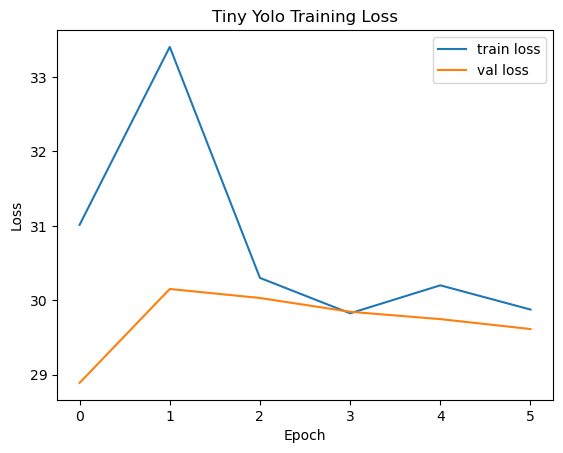

In [12]:
history_tiny_df = pd.read_csv('history/training_tiny.csv')

plt.plot(history_tiny_df['loss'], label='train loss')
plt.plot(history_tiny_df['val_loss'], label='val loss')
plt.legend()
plt.title("Tiny Yolo Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

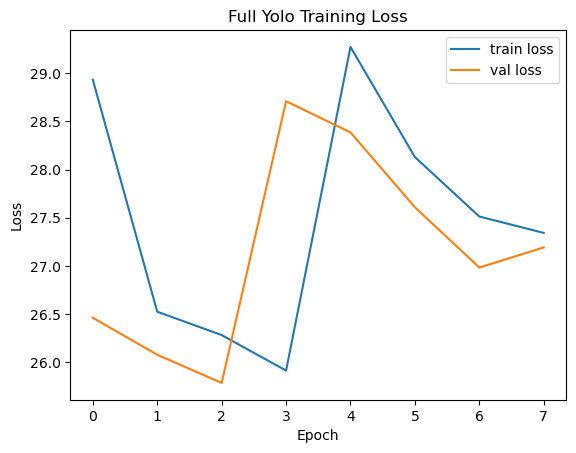

In [13]:
history_df = pd.read_csv('history/training.csv')

plt.plot(history_df['loss'], label='train loss')
plt.plot(history_df['val_loss'], label='val loss')
plt.legend()
plt.title("Full Yolo Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()